## Objectives
  - 

## Importing libraries

In [684]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import skew , kurtosis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.metrics import mean_absolute_percentage_error

## Reading data 

In [685]:
df = pd.read_csv('train.csv')

In [686]:
change_dict = {'warehouse_ID':'whouseid',
               'Product_Type':'ptype',
               'is_weekend':'weekend',
               'is_warehouse_closed':'whclosed',
               'daily_dispatch_count':'ddcount',
               'weekly_dispatch_count':'wdcount'}

In [687]:
df.rename(columns=change_dict,inplace=True)

In [688]:
len(df.ID.unique()) == len(df)

True

In [689]:
df.head()

,ID,date,whouseid,Latitude,Longitude,ptype,year,month,weekend,whclosed,ddcount,wdcount
0,0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,Yes,No,5.5,5.5
1,0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,January,Yes,No,6.1,6.1
2,0x2711,2017-01-02,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,No,No,4.8,NaN
3,0x33e7,2017-01-02,WH_0x3ea,38.749077,-105.183060,Type_A,2017,January,No,No,6.7,NaN
4,0x2712,2017-01-03,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,No,No,5.8,NaN


## Data Preparation
  - Search for Missing Values 
  - Finding correlation between features 
  - droping unnecessary features
  - Adding meaningful features

In [619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644 entries, 0 to 16643
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         16644 non-null  object 
 1   date       16644 non-null  object 
 2   whouseid   16644 non-null  object 
 3   Latitude   16312 non-null  float64
 4   Longitude  16228 non-null  float64
 5   ptype      16644 non-null  object 
 6   year       16644 non-null  int64  
 7   month      16644 non-null  object 
 8   weekend    16145 non-null  object 
 9   whclosed   16478 non-null  object 
 10  ddcount    16644 non-null  float64
 11  wdcount    2372 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.5+ MB


- features with missing values
   - Latitude , Longitude, weekend , whclosed, ddcount , wdcount.

In [620]:
df.describe()

,Latitude,Longitude,year,ddcount,wdcount
count,16312.000000,16228.000000,16644.000000,16644.000000,2372.000000
mean,37.721350,-93.987807,2019.442802,5.042640,35.233938
std,7.403689,17.907439,1.058141,3.304978,20.953378
min,25.750156,-149.125259,2017.000000,0.000000,0.000000
25%,34.361664,-105.183060,2019.000000,2.800000,19.475000
50%,37.915825,-87.551186,2020.000000,4.400000,30.100000
75%,41.681471,-80.279640,2020.000000,7.500000,52.000000
max,61.600803,-72.794746,2021.000000,17.900000,96.400000


In [621]:
df.describe(include=object)

,ID,date,whouseid,ptype,month,weekend,whclosed
count,16644,16644,16644,16644,16644,16145,16478
unique,16644,1581,10,2,12,2,2
top,0x2710,2021-04-30,WH_0x3e9,Type_A,March,No,No
freq,1,20,2796,8688,1674,11549,15365


- About latitude and longitude
  - see
  - They are perfectly correlated with ware house ID, see the following check

In [622]:
print(len(df.Latitude.unique()))  # 11 including 1 'nan' , actualy 10 unique pairs of latititude and longitude
print(len(df.Latitude.unique()) == len(df.Longitude.unique())) 
df.Latitude.unique(),df.Longitude.unique()

11
True


(array([41.681471, 38.749077,       nan, 35.67897 , 34.361664, 25.750156,
        30.189375, 41.611603, 48.692551, 37.915825, 61.600803]),
 array([ -72.794746, -105.18306 ,         nan, -109.067413,  -86.305595,
         -80.27964 ,  -82.648254,  -87.551186, -116.319862,  -89.829262,
        -149.125259]))

In [623]:
rows_where_either_lat_long_missing = len(df[(df.Latitude.isnull() | df.Longitude.isnull())])
rows_where_both_lat_long_missing   = len(df[(df.Latitude.isnull() & df.Longitude.isnull())])
rows_to_be_imputed = rows_where_either_lat_long_missing - rows_where_both_lat_long_missing 

In [624]:
'{} rows are there where either Latitude or Longitude values are missing.By observation,latitude-longitude pairs are unique,so wherever one is missing it can be filled.There are {} rows where both latitude and logitude values are missing they need to be dropped, so {} rows can be easily saved from leaking'.format(rows_where_either_lat_long_missing,rows_where_both_lat_long_missing,rows_to_be_imputed)

'736 rows are there where either Latitude or Longitude values are missing.By observation,latitude-longitude pairs are unique,so wherever one is missing it can be filled.There are 12 rows where both latitude and logitude values are missing they need to be dropped, so 724 rows can be easily saved from leaking'

In [625]:
df.fillna('mv',inplace=True)
latitudes = list(df.Latitude.unique())
latitudes.remove('mv')

In [626]:
for feature in df.columns:
    print(feature,len(df[df[feature]=='mv']))

ID 0
date 0
whouseid 0
Latitude 332
Longitude 416
ptype 0
year 0
month 0
weekend 499
whclosed 166
ddcount 0
wdcount 14272


In [627]:
lat_lon_pairs = []
for lat in latitudes:
    long = df[df.Latitude == lat]['Longitude'].iloc[1]
    lat_lon_pairs.append((lat,long))

print(lat_lon_pairs)

[(41.681471, -72.79474599999999), (38.749077, -105.18306), (35.67897, -109.067413), (34.361664000000005, -86.305595), (25.750156, -80.27964), (30.189375, -82.64825400000001), (41.611603, -87.551186), (48.692551, -116.319862), (37.915825, -89.829262), (61.600803000000006, -149.125259)]


In [628]:
for i in range(len(df)):
    if df.Latitude.iloc[i] and df.Longitude.iloc[i] == 'mv':
        for lat_lon_pair in lat_lon_pairs:
            if df.Latitude.iloc[i] == lat_lon_pair[0]:
                df.iloc[i,df.columns.get_loc('Longitude')] = lat_lon_pair[1]
    if df.Longitude.iloc[i] and df.Latitude.iloc[i] == 'mv':
        for lat_lon_pair in lat_lon_pairs:
            if df.Longitude.iloc[i] == lat_lon_pair[1]:
                df.iloc[i,df.columns.get_loc('Latitude')] = lat_lon_pair[0]

In [629]:
rows_where_either_lat_long_missing = len(df[(df.Latitude.isnull() | df.Longitude.isnull())])
rows_where_both_lat_long_missing   = len(df[(df.Latitude.isnull() & df.Longitude.isnull())])
rows_where_both_lat_long_missing == rows_where_either_lat_long_missing

True

#

In [630]:
df=df[df['Latitude'] != 'mv']
df=df.reset_index()
df.drop(columns=['index'],axis=1,inplace=True)

- Current status of missing values

In [631]:
for feature in df.columns:
    print(feature,len(df[df[feature]=='mv']))

ID 0
date 0
whouseid 0
Latitude 0
Longitude 0
ptype 0
year 0
month 0
weekend 499
whclosed 166
ddcount 0
wdcount 14262


-  To fill weekend column

In [632]:
# weekend missing values can be dealt with date time processing 
df['date'] = pd.to_datetime(df['date'])
df.dtypes


ID                   object
date         datetime64[ns]
whouseid             object
Latitude             object
Longitude            object
ptype                object
year                  int64
month                object
weekend              object
whclosed             object
ddcount             float64
wdcount              object
dtype: object

In [633]:
df.weekend.unique()

array(['Yes', 'No', 'mv'], dtype=object)

In [634]:
df['weekend']=df['date'].dt.dayofweek > 4

In [635]:
df.weekend.unique()

array([ True, False])

In [636]:
for feature in df.columns:
    print(feature,':',len(df[df[feature]=='mv']))

ID : 0
date : 0
whouseid : 0
Latitude : 0
Longitude : 0
ptype : 0
year : 0
month : 0
weekend : 0
whclosed : 166
ddcount : 0
wdcount : 14262


- About whclosed 

In [637]:
df.whclosed.value_counts()

No     15353
Yes     1113
mv       166
Name: whclosed, dtype: int64

In [638]:
df=df[df['whclosed']!= 'mv']

In [639]:
for feature in df.columns:
    print(feature,len(df[df[feature]=='mv']))

ID 0
date 0
whouseid 0
Latitude 0
Longitude 0
ptype 0
year 0
month 0
weekend 0
whclosed 0
ddcount 0
wdcount 14115


In [640]:
df.head()

,ID,date,whouseid,Latitude,Longitude,ptype,year,month,weekend,whclosed,ddcount,wdcount
0,0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,True,No,5.5,5.5
1,0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.18306,Type_A,2017,January,True,No,6.1,6.1
2,0x2711,2017-01-02,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,False,No,4.8,mv
3,0x33e7,2017-01-02,WH_0x3ea,38.749077,-105.18306,Type_A,2017,January,False,No,6.7,mv
4,0x2712,2017-01-03,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,False,No,5.8,mv


In [641]:
for whid in df['whouseid'].unique():
    
    print(whid,df[df['whouseid']==whid].Latitude.unique(),df[df['whouseid']==whid].Longitude.unique())

WH_0x3e9 [41.681471] [-72.79474599999999]
WH_0x3ea [38.749077] [-105.18306]
WH_0x3eb [35.67897] [-109.067413]
WH_0x3ec [34.361664000000005] [-86.305595]
WH_0x3ed [25.750156] [-80.27964]
WH_0x3ee [30.189375] [-82.64825400000001]
WH_0x3ef [41.611603] [-87.551186]
WH_0x3f1 [48.692551] [-116.319862]
WH_0x3f0 [37.915825] [-89.829262]
WH_0x3f2 [61.600803000000006] [-149.125259]


####  Two different traing data set for two targets

In [642]:
data_daily = df.drop(columns= ['ID','Latitude','Longitude','wdcount'])

In [643]:
data_daily.head()

,date,whouseid,ptype,year,month,weekend,whclosed,ddcount
0,2017-01-01,WH_0x3e9,Type_A,2017,January,True,No,5.5
1,2017-01-01,WH_0x3ea,Type_A,2017,January,True,No,6.1
2,2017-01-02,WH_0x3e9,Type_A,2017,January,False,No,4.8
3,2017-01-02,WH_0x3ea,Type_A,2017,January,False,No,6.7
4,2017-01-03,WH_0x3e9,Type_A,2017,January,False,No,5.8


- if a date weekday or weekend may effect daily dispatch so we need to add this column 

In [644]:
data_weekly= df.drop(columns=['ID','Latitude','Longitude','ddcount'])

In [645]:
data_weekly = data_weekly[data_weekly['wdcount']!= 'mv']

In [646]:
data_weekly.head()

,date,whouseid,ptype,year,month,weekend,whclosed,wdcount
0,2017-01-01,WH_0x3e9,Type_A,2017,January,True,No,5.5
1,2017-01-01,WH_0x3ea,Type_A,2017,January,True,No,6.1
14,2017-01-08,WH_0x3e9,Type_A,2017,January,True,No,37.1
15,2017-01-08,WH_0x3ea,Type_A,2017,January,True,No,48.3
28,2017-01-15,WH_0x3e9,Type_A,2017,January,True,No,37.5


In [647]:
df.head()

,ID,date,whouseid,Latitude,Longitude,ptype,year,month,weekend,whclosed,ddcount,wdcount
0,0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,True,No,5.5,5.5
1,0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.18306,Type_A,2017,January,True,No,6.1,6.1
2,0x2711,2017-01-02,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,False,No,4.8,mv
3,0x33e7,2017-01-02,WH_0x3ea,38.749077,-105.18306,Type_A,2017,January,False,No,6.7,mv
4,0x2712,2017-01-03,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,False,No,5.8,mv


## Visulaization and exploration

In [648]:
data_daily.dtypes

date        datetime64[ns]
whouseid            object
ptype               object
year                 int64
month               object
weekend               bool
whclosed            object
ddcount            float64
dtype: object

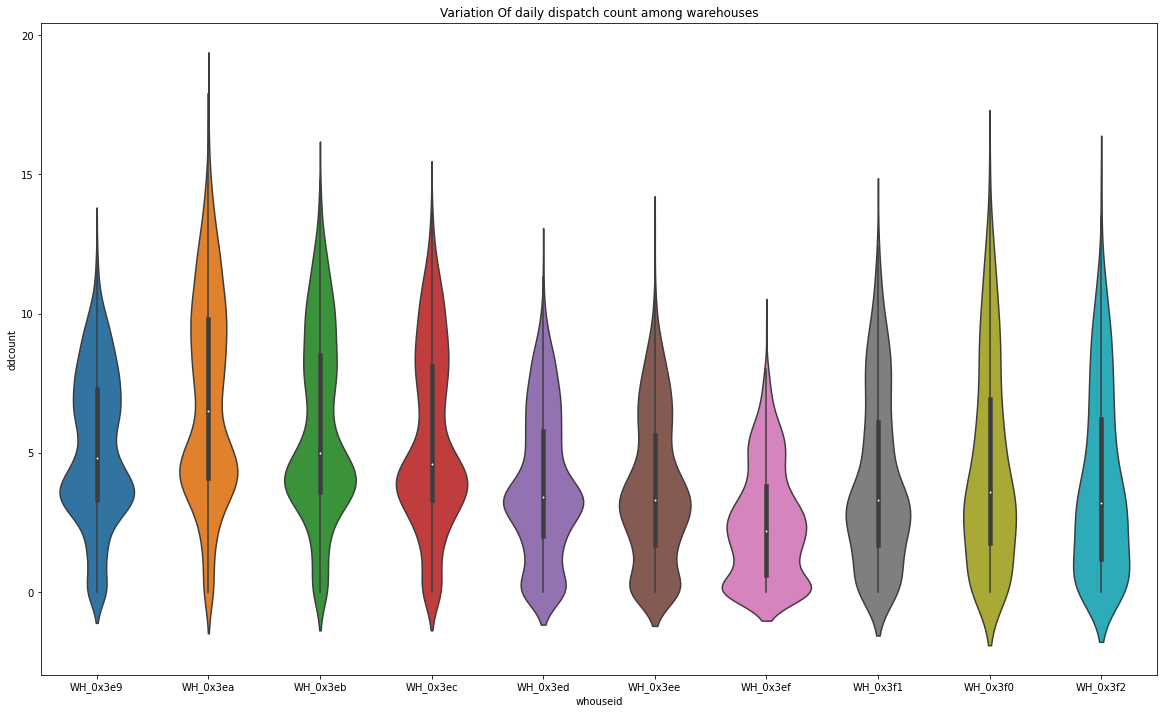

In [649]:
plt.figure(figsize=(20,12))
sns.violinplot(x='whouseid',y='ddcount', data=data_daily).set_title('Variation Of daily dispatch count among warehouses')
plt.show()

In [650]:
data_weekly['wdcount']=data_weekly['wdcount'].astype(int)

In [651]:
data_weekly.dtypes

date        datetime64[ns]
whouseid            object
ptype               object
year                 int64
month               object
weekend               bool
whclosed            object
wdcount              int64
dtype: object

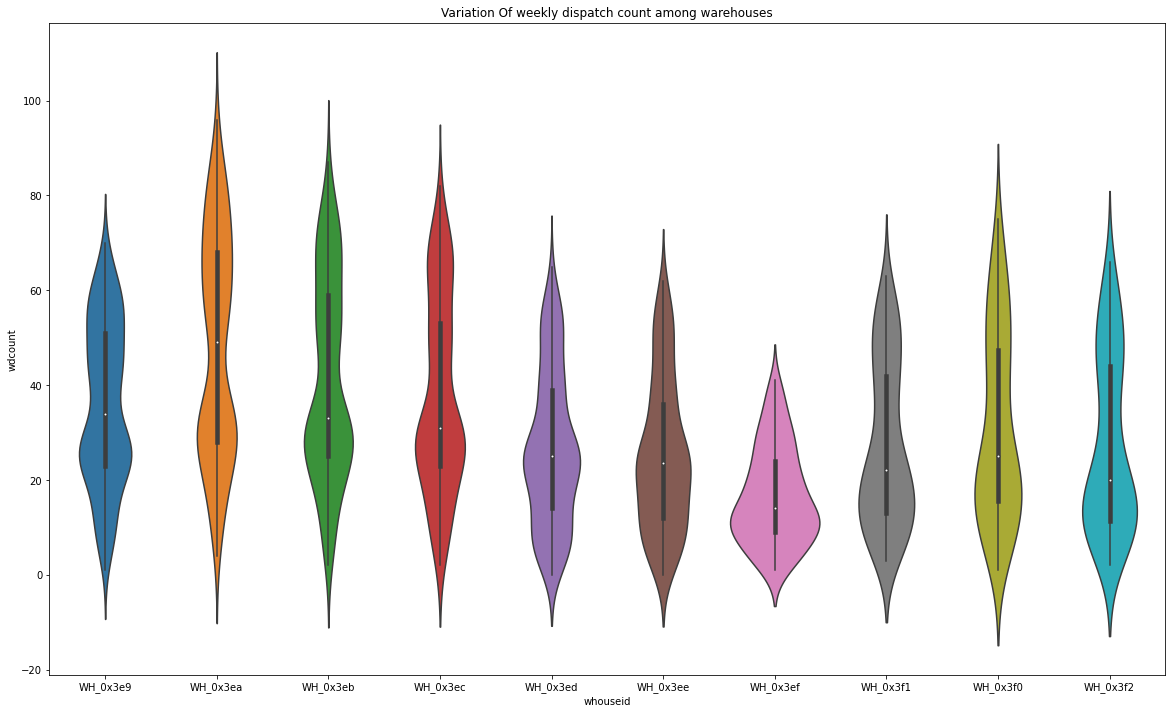

In [652]:
plt.figure(figsize=(20,12))
sns.violinplot(x='whouseid',y='wdcount', data=data_weekly).set_title('Variation Of weekly dispatch count among warehouses')
plt.show()

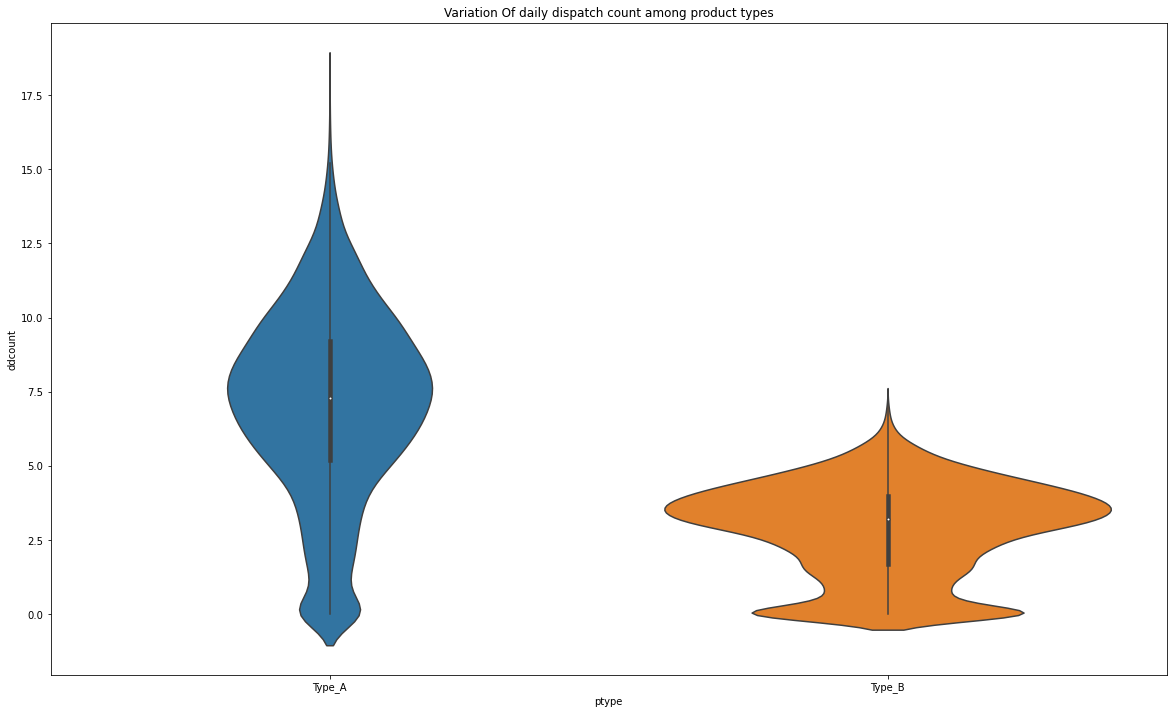

In [653]:
plt.figure(figsize=(20,12))
sns.violinplot(x='ptype',y='ddcount', data=data_daily).set_title('Variation Of daily dispatch count among product types')
plt.show()

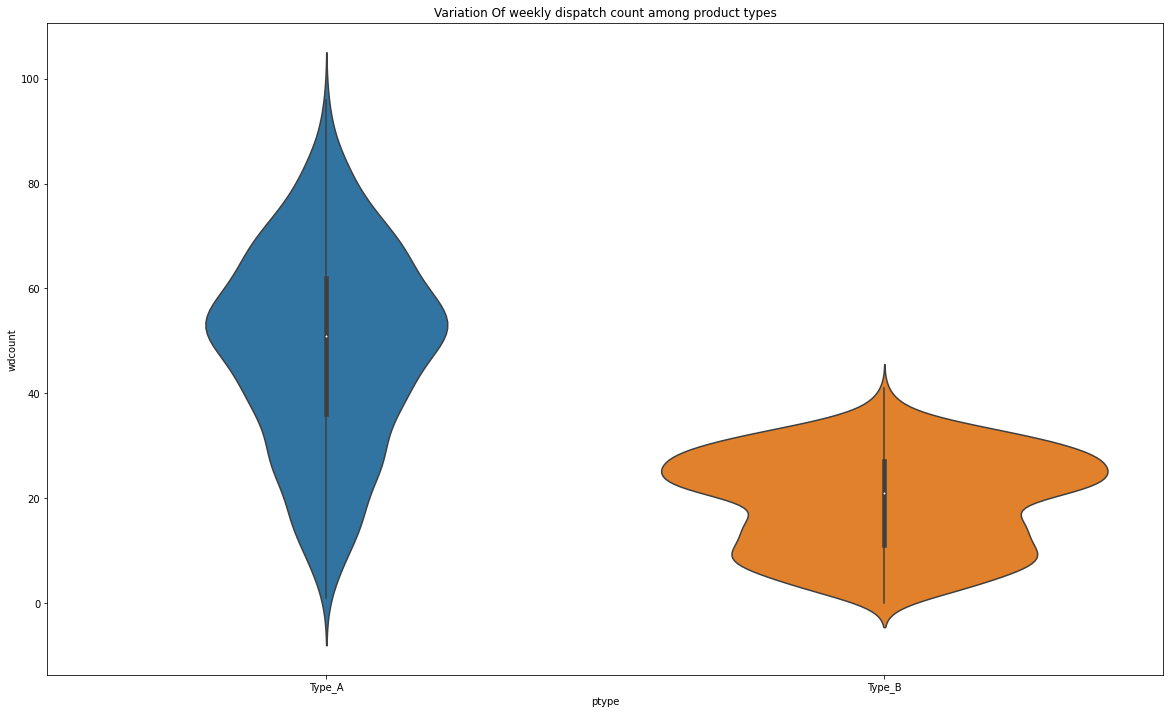

In [654]:
plt.figure(figsize=(20,12))
sns.violinplot(x='ptype',y='wdcount', data=data_weekly).set_title('Variation Of weekly dispatch count among product types')
plt.show()

<AxesSubplot:xlabel='ptype', ylabel='Count'>

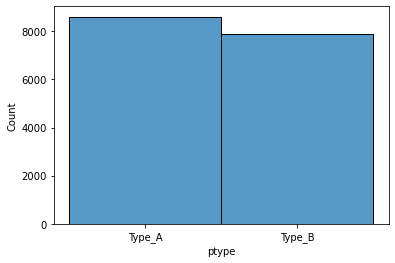

In [655]:
sns.histplot(x='ptype',data=data_daily)

<AxesSubplot:xlabel='ptype', ylabel='Count'>

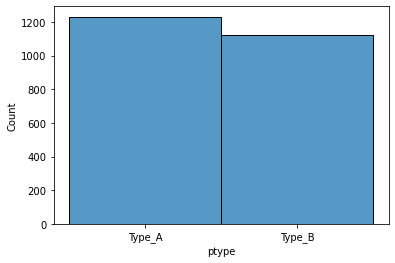

In [656]:
sns.histplot(x='ptype',data=data_weekly)

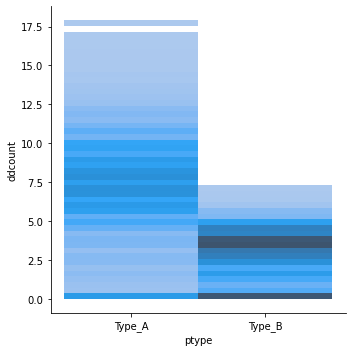

In [657]:
sns.displot(x='ptype',y='ddcount',data=data_daily)

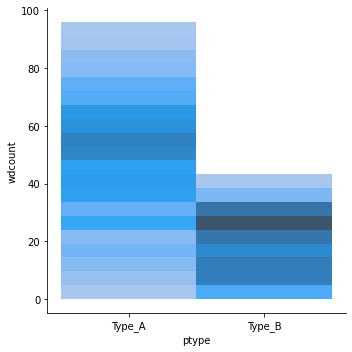

In [658]:
sns.displot(x='ptype',y='wdcount',data=data_weekly)

<AxesSubplot:xlabel='ddcount', ylabel='Density'>

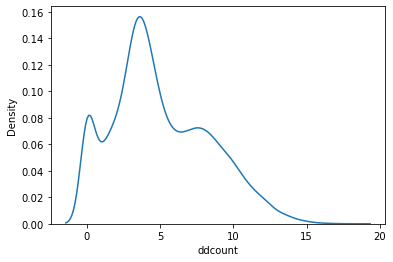

In [659]:
sns.kdeplot(x='ddcount',data=data_daily)

In [660]:
skew(data_daily.ddcount),kurtosis(data_daily.ddcount)

(0.4930791691350866, -0.397806051302676)

<AxesSubplot:xlabel='wdcount', ylabel='Density'>

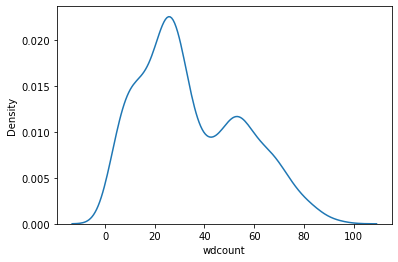

In [661]:
sns.kdeplot(x='wdcount',data=data_weekly)

In [662]:
skew(data_weekly.wdcount),kurtosis(data_weekly.wdcount)

(0.508314235927628, -0.6489581348190279)

In [663]:
data_daily[data_daily['whouseid']=='WH_0x3e9']

,date,whouseid,ptype,year,month,weekend,whclosed,ddcount
0,2017-01-01,WH_0x3e9,Type_A,2017,January,True,No,5.5
2,2017-01-02,WH_0x3e9,Type_A,2017,January,False,No,4.8
4,2017-01-03,WH_0x3e9,Type_A,2017,January,False,No,5.8
6,2017-01-04,WH_0x3e9,Type_A,2017,January,False,No,6.6
8,2017-01-05,WH_0x3e9,Type_A,2017,January,False,No,4.9
...,...,...,...,...,...,...,...,...
16573,2021-04-28,WH_0x3e9,Type_B,2021,April,False,Yes,0.0
16592,2021-04-29,WH_0x3e9,Type_A,2021,April,False,No,2.1
16593,2021-04-29,WH_0x3e9,Type_B,2021,April,False,No,3.0
16612,2021-04-30,WH_0x3e9,Type_A,2021,April,False,No,3.1


In [664]:
average_daily_dispatch=[]
for whid in data_daily.whouseid.unique():
    average_daily_dispatch.append((whid,data_daily[data_daily['whouseid']==whid].ddcount.mean()))
    

Text(0.5, 1.0, 'Average daily dispatch for individual warehouses')

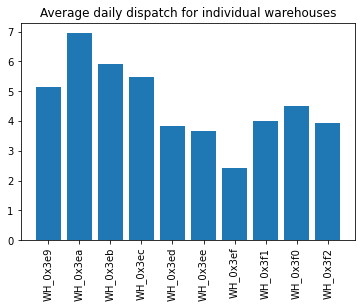

In [665]:
plt.xticks(rotation=90)
plt.bar(*zip(*average_daily_dispatch))
plt.title('Average daily dispatch for individual warehouses')

In [666]:
data_daily.describe()

,year,ddcount
count,16466.000000,16466.000000
mean,2019.443824,5.042761
std,1.056915,3.305474
min,2017.000000,0.000000
25%,2019.000000,2.800000
50%,2020.000000,4.400000
75%,2020.000000,7.500000
max,2021.000000,17.900000


## Finding trends for time series 

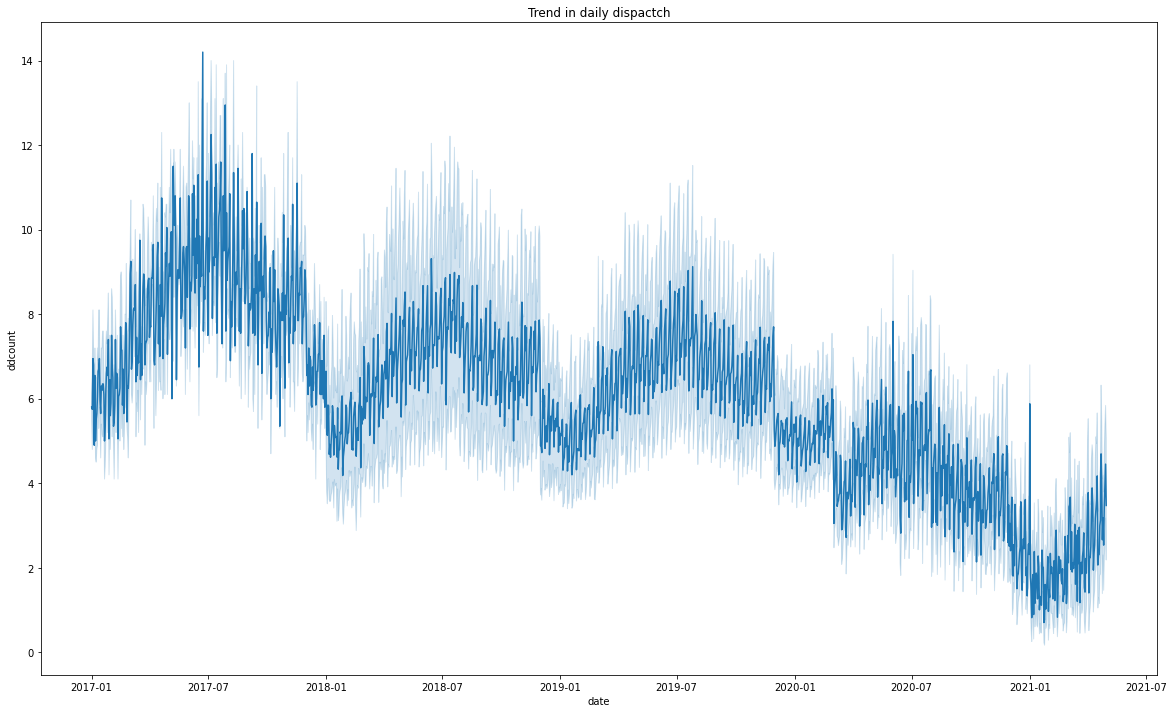

In [667]:

plt.figure(figsize=(20,12))

sns.lineplot(x='date',y='ddcount',data=data_daily)
plt.title('Trend in daily dispactch')
plt.show()

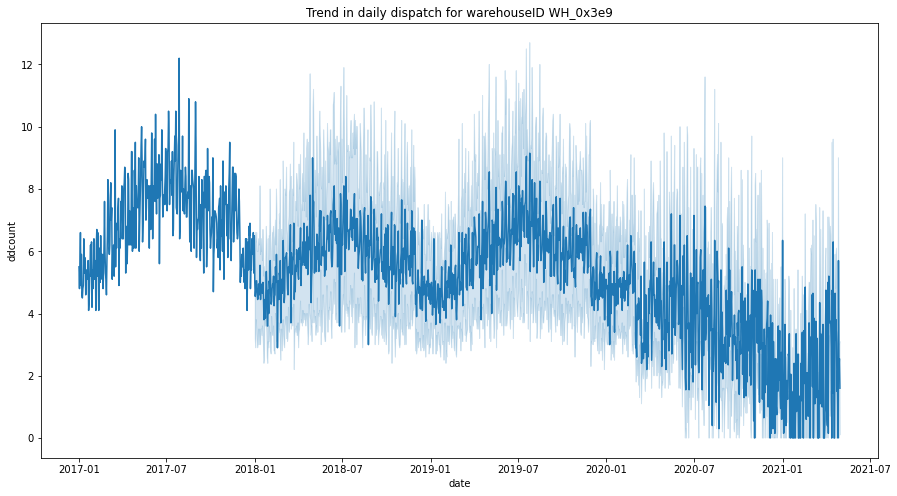

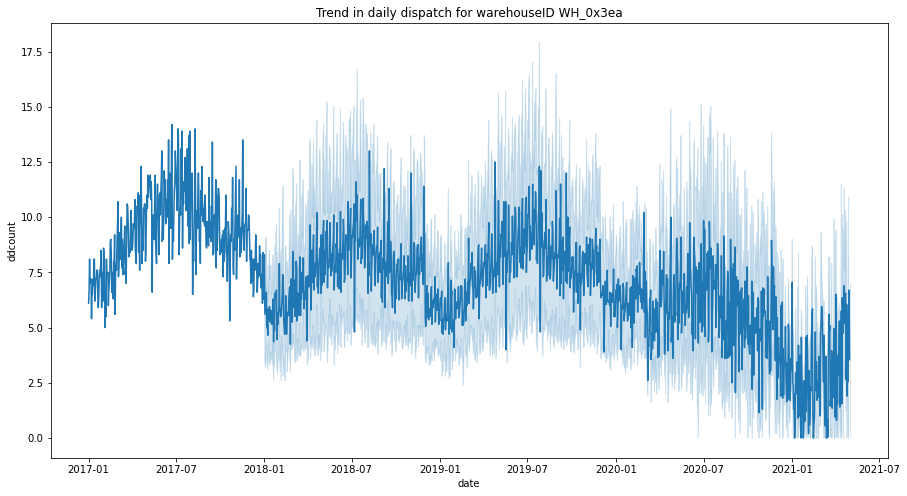

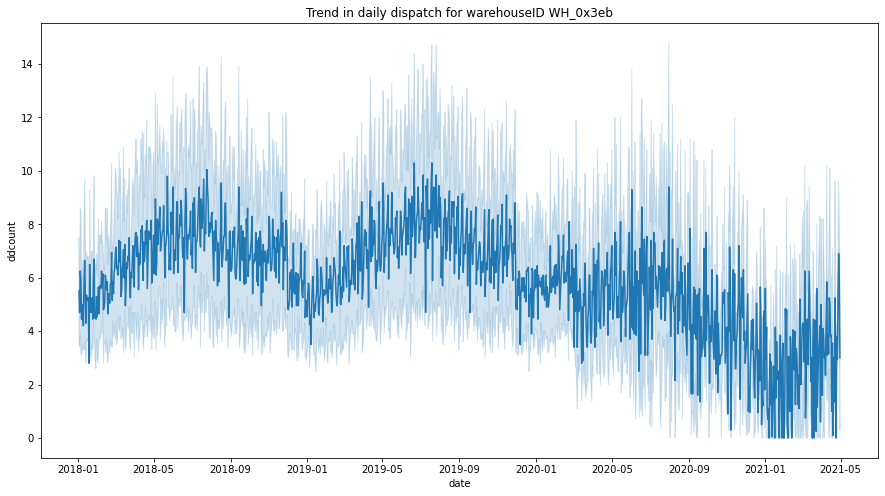

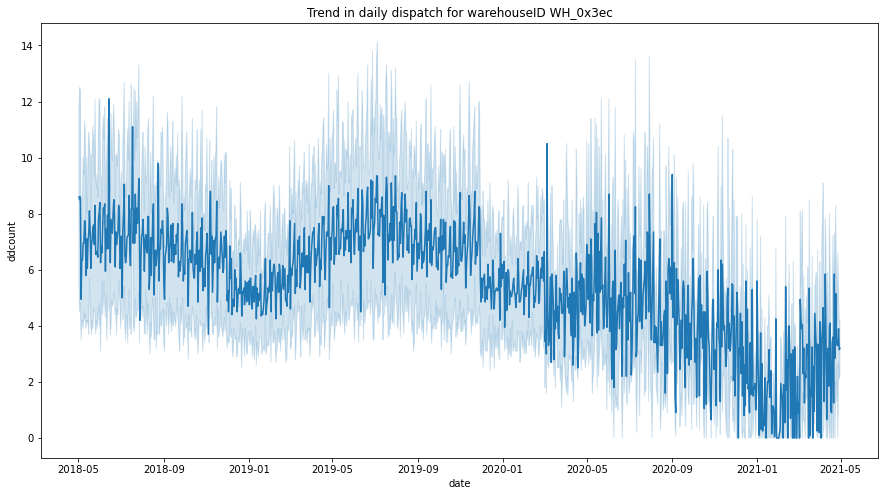

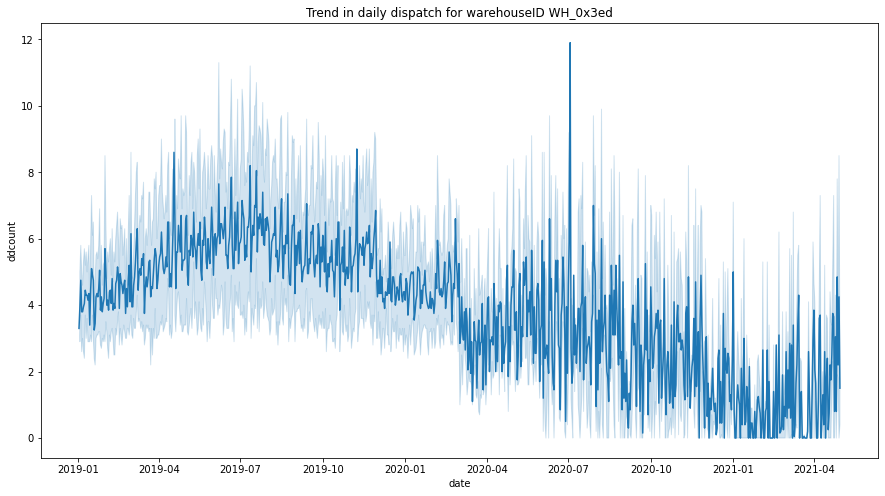

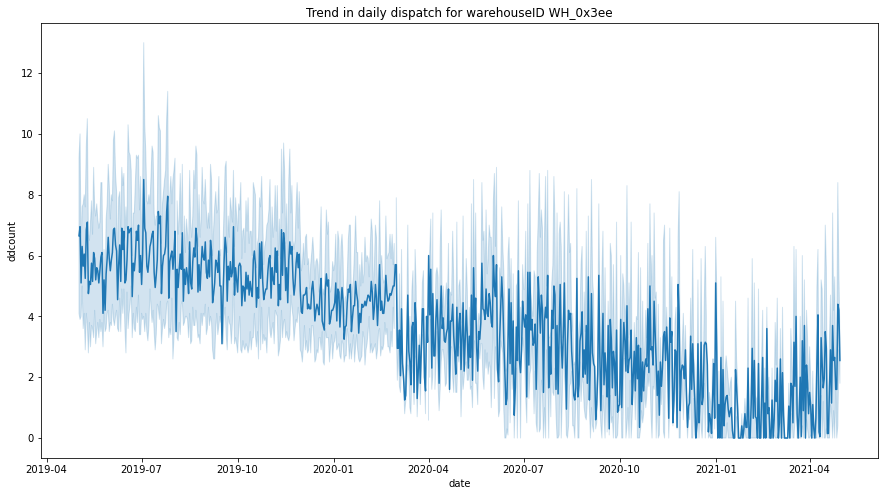

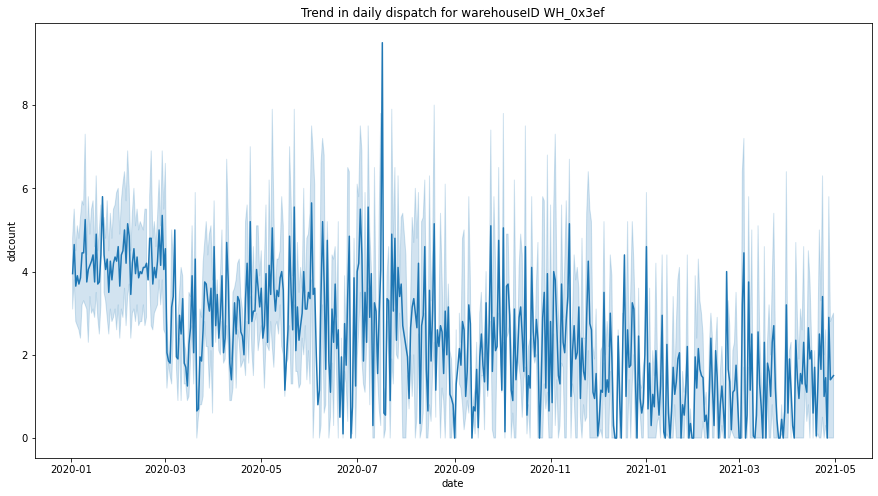

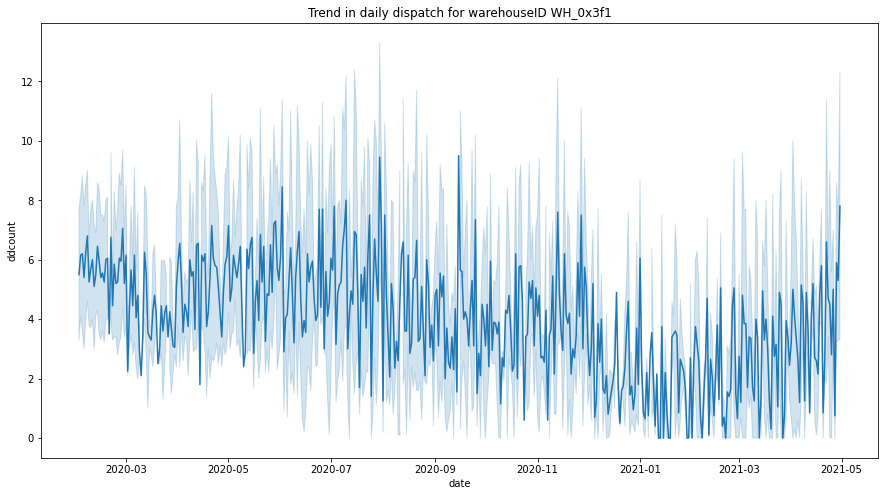

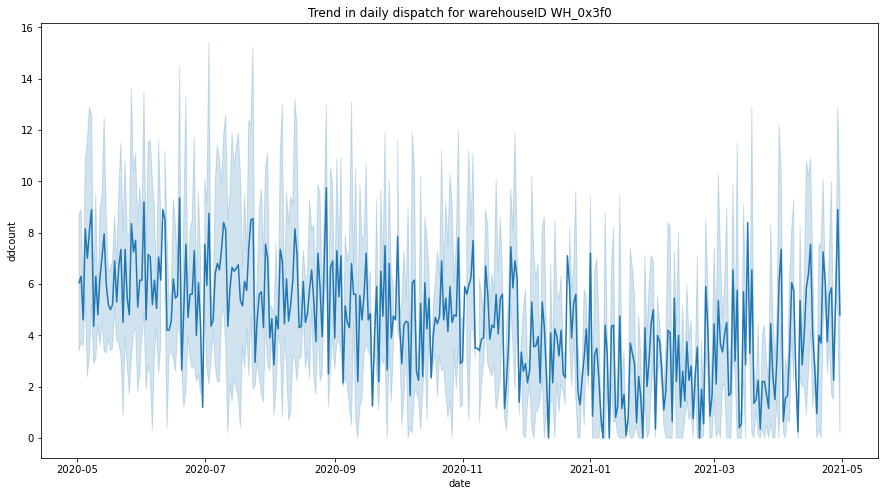

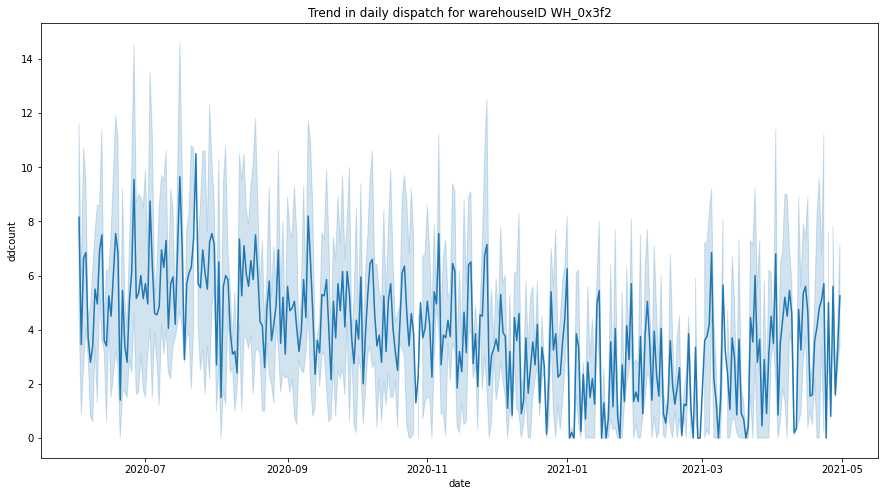

In [668]:
for whid in data_daily.whouseid.unique():
    plt.figure(figsize=(15,8))
    sns.lineplot(x='date',y='ddcount',data=data_daily[data_daily['whouseid']==whid])
    plt.title('Trend in daily dispatch for warehouseID {}'.format(whid))
    plt.show()

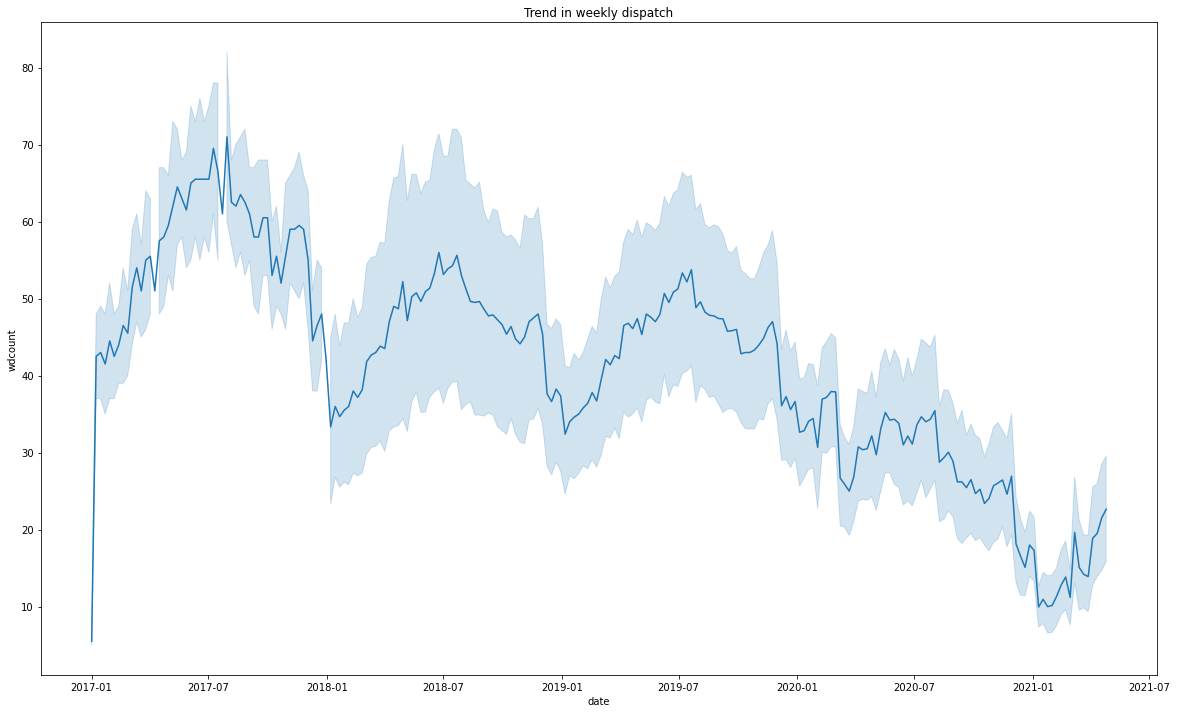

In [669]:

plt.figure(figsize=(20,12))
plt.title('Trend in weekly dispatch')
sns.lineplot(x='date',y='wdcount',data=data_weekly)
plt.show()

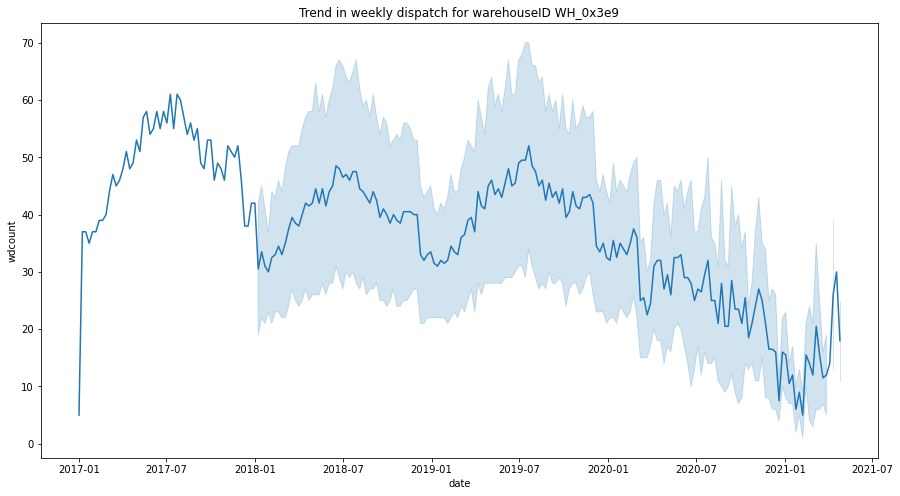

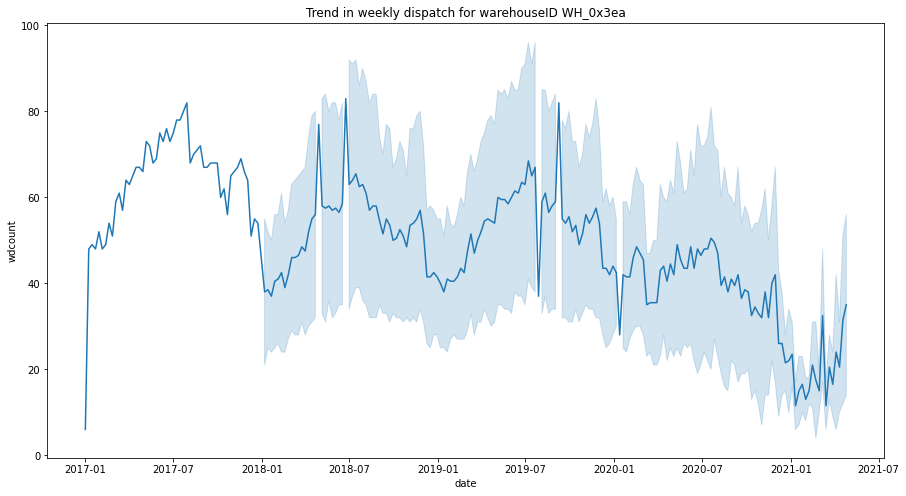

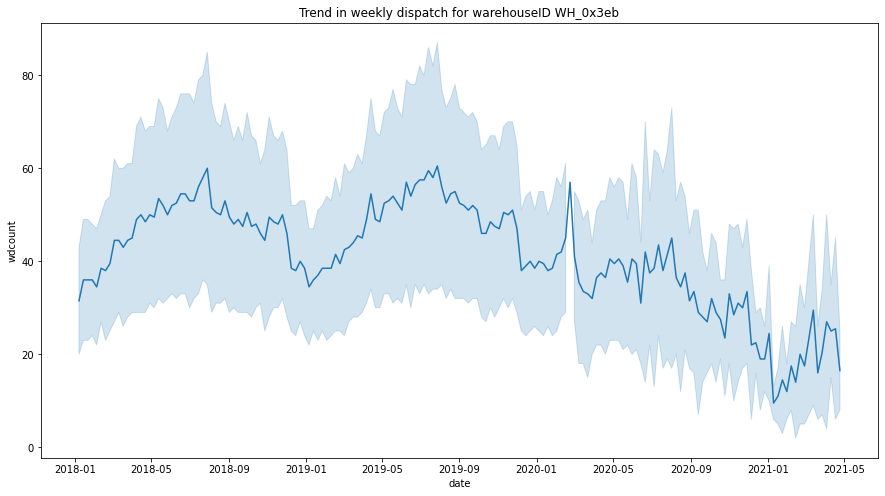

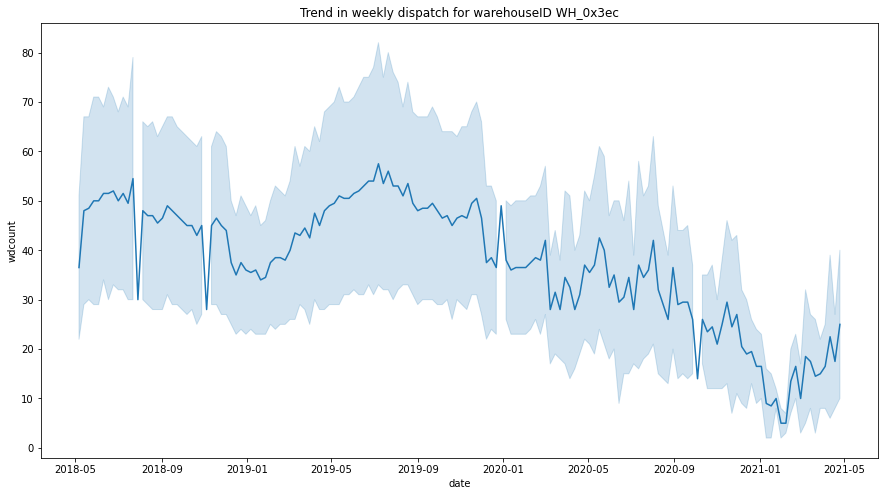

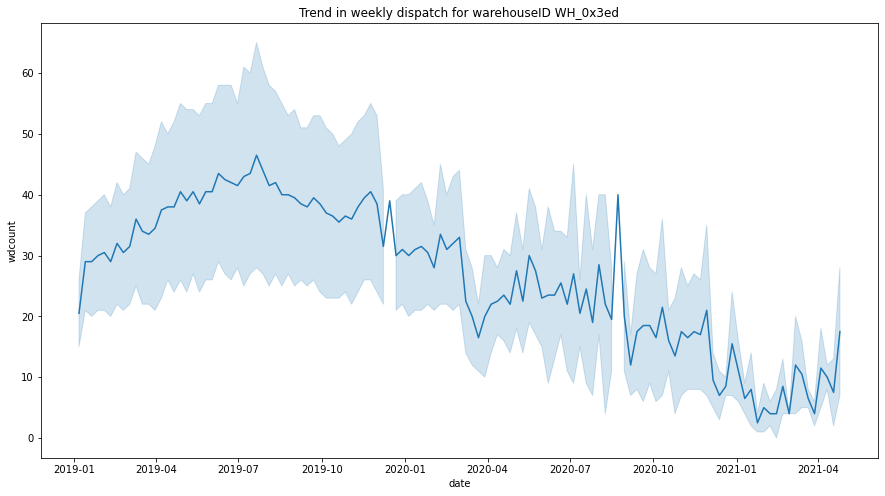

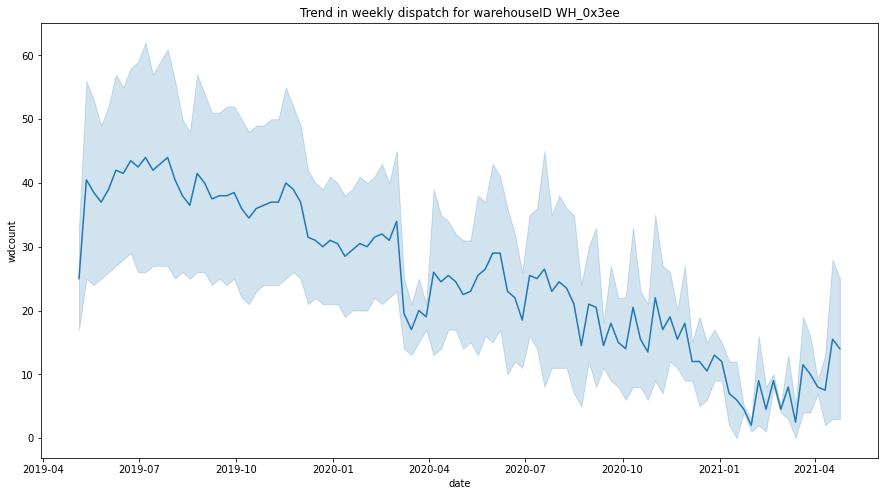

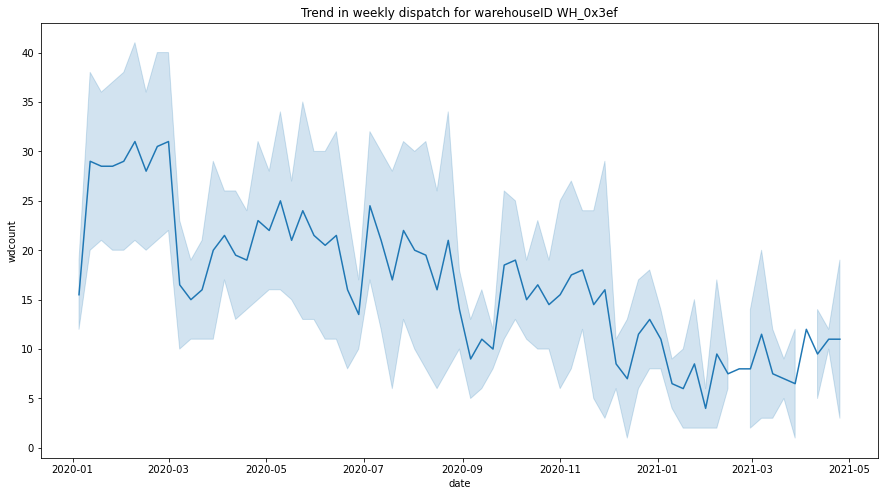

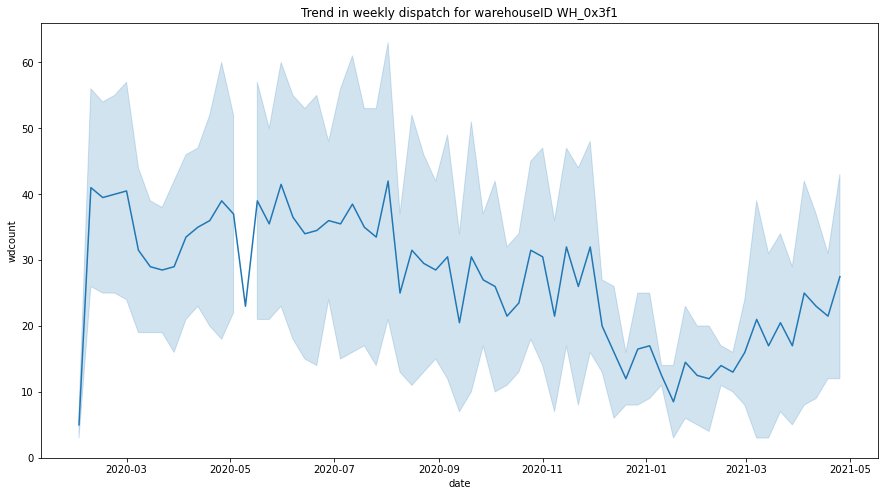

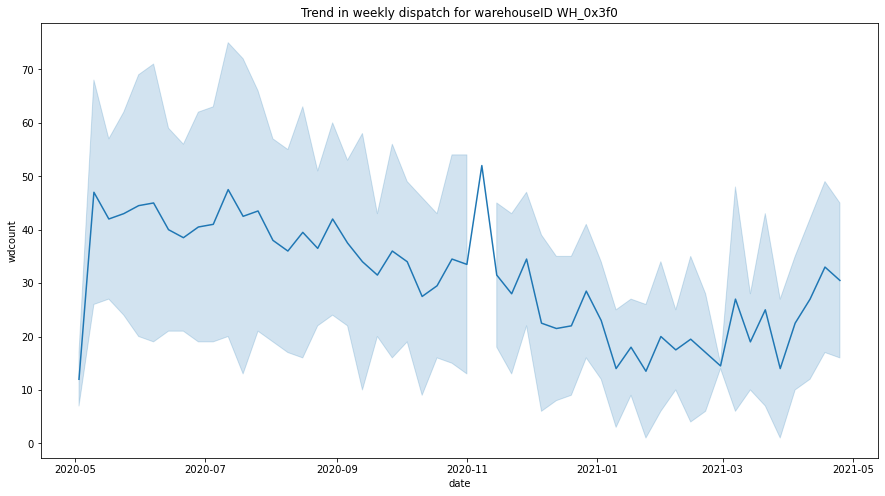

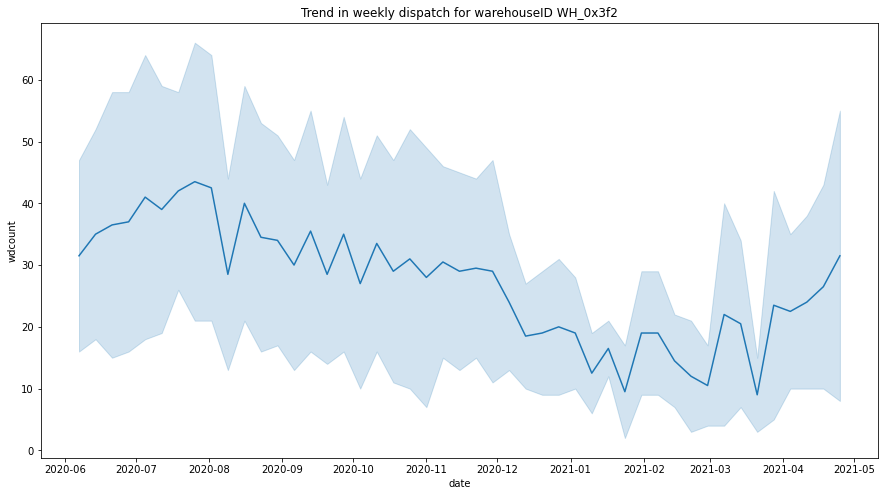

In [670]:
for whid in data_weekly.whouseid.unique():
    plt.figure(figsize=(15,8))
    sns.lineplot(x='date',y='wdcount',data=data_weekly[data_weekly['whouseid']==whid])
    plt.title('Trend in weekly dispatch for warehouseID {}'.format(whid))
    plt.show()

In [671]:
data_daily.head()

,date,whouseid,ptype,year,month,weekend,whclosed,ddcount
0,2017-01-01,WH_0x3e9,Type_A,2017,January,True,No,5.5
1,2017-01-01,WH_0x3ea,Type_A,2017,January,True,No,6.1
2,2017-01-02,WH_0x3e9,Type_A,2017,January,False,No,4.8
3,2017-01-02,WH_0x3ea,Type_A,2017,January,False,No,6.7
4,2017-01-03,WH_0x3e9,Type_A,2017,January,False,No,5.8


In [672]:
data_daily.dtypes

date        datetime64[ns]
whouseid            object
ptype               object
year                 int64
month               object
weekend               bool
whclosed            object
ddcount            float64
dtype: object

In [673]:
data_daily.drop(columns=['year'],inplace=True)
data_daily['weekend']=data_daily['weekend'].astype(str)
data_daily.drop(columns=['date'],axis=1,inplace = True)


In [674]:
data_daily.dtypes

whouseid     object
ptype        object
month        object
weekend      object
whclosed     object
ddcount     float64
dtype: object

In [675]:
data_daily = pd.get_dummies(data_daily)

In [676]:
data_daily.head()

,ddcount,whouseid_WH_0x3e9,whouseid_WH_0x3ea,whouseid_WH_0x3eb,whouseid_WH_0x3ec,whouseid_WH_0x3ed,whouseid_WH_0x3ee,whouseid_WH_0x3ef,whouseid_WH_0x3f0,whouseid_WH_0x3f1,...,month_June,month_March,month_May,month_November,month_October,month_September,weekend_False,weekend_True,whclosed_No,whclosed_Yes
0,5.5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,6.1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,4.8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,6.7,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,5.8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [677]:
data_weekly.head()


,date,whouseid,ptype,year,month,weekend,whclosed,wdcount
0,2017-01-01,WH_0x3e9,Type_A,2017,January,True,No,5
1,2017-01-01,WH_0x3ea,Type_A,2017,January,True,No,6
14,2017-01-08,WH_0x3e9,Type_A,2017,January,True,No,37
15,2017-01-08,WH_0x3ea,Type_A,2017,January,True,No,48
28,2017-01-15,WH_0x3e9,Type_A,2017,January,True,No,37


In [678]:
data_weekly.dtypes

date        datetime64[ns]
whouseid            object
ptype               object
year                 int64
month               object
weekend               bool
whclosed            object
wdcount              int64
dtype: object

In [487]:
dadata_weekly.drop(columns=['year'],inplace=True)
data_weekly['weekend']=data_weekly['weekend'].astype(str)
data_weekly.drop(columns=['date'],axis=1,inplace = True)

In [488]:
data_weekly.dtypes

whouseid    object
ptype       object
year        object
month       object
weekend     object
whclosed    object
wdcount      int64
dtype: object

In [489]:
data_weekly = pd.get_dummies(data_weekly)

In [490]:
data_weekly.head()

,wdcount,whouseid_WH_0x3e9,whouseid_WH_0x3ea,whouseid_WH_0x3eb,whouseid_WH_0x3ec,whouseid_WH_0x3ed,whouseid_WH_0x3ee,whouseid_WH_0x3ef,whouseid_WH_0x3f0,whouseid_WH_0x3f1,...,month_July,month_June,month_March,month_May,month_November,month_October,month_September,weekend_True,whclosed_No,whclosed_Yes
0,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
14,37,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15,48,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
28,37,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


# Modelling 
   - Training set , holdout set for evaluation of our model

   - pipelining 
   - hyperparameter tuning 

In [492]:
X_daily = data_daily.drop(columns=['ddcount'])
y_daily = data_daily['ddcount']
X_weekly = data_weekly.drop(columns=['wdcount'])
y_weekly = data_weekly['wdcount']

In [493]:
X_daily

,whouseid_WH_0x3e9,whouseid_WH_0x3ea,whouseid_WH_0x3eb,whouseid_WH_0x3ec,whouseid_WH_0x3ed,whouseid_WH_0x3ee,whouseid_WH_0x3ef,whouseid_WH_0x3f0,whouseid_WH_0x3f1,whouseid_WH_0x3f2,...,month_June,month_March,month_May,month_November,month_October,month_September,weekend_False,weekend_True,whclosed_No,whclosed_Yes
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16627,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
16628,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
16629,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
16630,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [494]:
y_daily

0         5.5
1         6.1
2         4.8
3         6.7
4         5.8
         ... 
16627     0.2
16628    12.3
16629     3.3
16630     7.1
16631     3.4
Name: ddcount, Length: 16466, dtype: float64

In [495]:
X_weekly

,whouseid_WH_0x3e9,whouseid_WH_0x3ea,whouseid_WH_0x3eb,whouseid_WH_0x3ec,whouseid_WH_0x3ed,whouseid_WH_0x3ee,whouseid_WH_0x3ef,whouseid_WH_0x3f0,whouseid_WH_0x3f1,whouseid_WH_0x3f2,...,month_July,month_June,month_March,month_May,month_November,month_October,month_September,weekend_True,whclosed_No,whclosed_Yes
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
14,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16527,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
16528,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
16529,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
16530,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [496]:
y_weekly

0         5
1         6
14       37
15       48
28       37
         ..
16527    16
16528    43
16529    12
16530    55
16531     8
Name: wdcount, Length: 2351, dtype: int64

#### training and validation set partition

In [497]:
X_daily_train,X_daily_valid,y_daily_train,y_daily_valid = train_test_split(X_daily,y_daily, test_size=0.2, random_state=1234) 

In [498]:
X_weekly_train,X_weekly_valid,y_weekly_train,y_weekly_valid = train_test_split(X_weekly,y_weekly, test_size=0.2, random_state=1234) 

In [499]:
X_daily_train.shape,X_daily_valid.shape, y_daily_train.shape ,y_daily_valid.shape

((13172, 33), (3294, 33), (13172,), (3294,))

In [500]:
X_weekly_train.shape,X_weekly_valid.shape, y_weekly_train.shape ,y_weekly_valid.shape

((1880, 32), (471, 32), (1880,), (471,))

## Pipeline

In [501]:
def train_via_pipline(training_set_X,traing_set_y):
    pipelines = {
    'Rf': make_pipeline(RandomForestRegressor(random_state=1234)),
    'Gb': make_pipeline(GradientBoostingRegressor(random_state=1234)),
    'Ridge': make_pipeline(Ridge(random_state=1234)),
    'Lasso': make_pipeline(Lasso(random_state=1234)),
    'Enet': make_pipeline(ElasticNet(random_state=1234))
}
    hparm_grid = {
    'Rf': {'randomforestregressor__min_samples_split':[2,4,6,8],
          'randomforestregressor__min_samples_leaf':[1,2,3]
    
          },
    'Gb': {'gradientboostingregressor__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]},
    'Ridge': {'ridge__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]},
    'Lasso': {'lasso__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]},
    'Enet':{'elasticnet__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]}
    
}
    fit_models={}
    for algorithm , pipeline in pipelines.items():
        model = GridSearchCV(pipeline,hparm_grid[algorithm],cv=10,n_jobs=-1)
        try:
            model.fit(training_set_X,traing_set_y)
            fit_models[algorithm] = model
            print('{} has been successfully fit'.format(algorithm))
        except NotFittedError as e :
            print(repr(e))
            
    return fit_models        
            

In [502]:
my_models_daily=train_via_pipline(X_daily_train,y_daily_train)

Rf has been successfully fit
Gb has been successfully fit
Ridge has been successfully fit
Lasso has been successfully fit
Enet has been successfully fit


In [503]:
my_models_weekly=train_via_pipline(X_weekly_train,y_weekly_train)

Rf has been successfully fit
Gb has been successfully fit
Ridge has been successfully fit


/usr/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.637e+02, tolerance: 7.330e+01
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.427e+02, tolerance: 7.473e+01
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.318e+02, tolerance: 7.433e+01
  model = cd_f

Lasso has been successfully fit
Enet has been successfully fit


## Testing , Performance Evaluation and finding the best model

 ## Best performing model

In [531]:
1-mean_absolute_percentage_error(my_models_daily['Rf'].predict(X_daily_valid),y_daily_valid)

0.7743736386069252

In [532]:
1-mean_absolute_percentage_error(my_models_weekly['Rf'].predict(X_weekly_valid),y_weekly_valid)

0.8485409336161079

In [533]:
1-mean_absolute_percentage_error(my_models_daily['Gb'].predict(X_daily_valid),y_daily_valid)

0.7059356952989485

In [535]:
1-mean_absolute_percentage_error(my_models_weekly['Gb'].predict(X_weekly_valid),y_weekly_valid)

0.8062218434314476

In [536]:
1-mean_absolute_percentage_error(my_models_daily['Ridge'].predict(X_daily_valid),y_daily_valid)

0.3833703447034834

In [537]:
1-mean_absolute_percentage_error(my_models_weekly['Ridge'].predict(X_weekly_valid),y_weekly_valid)

0.26909740541301264

In [538]:
1-mean_absolute_percentage_error(my_models_daily['Lasso'].predict(X_daily_valid),y_daily_valid)

-0.07855460967370087

In [539]:
1-mean_absolute_percentage_error(my_models_weekly['Lasso'].predict(X_weekly_valid),y_weekly_valid)

0.31986810965819856

In [540]:
1-mean_absolute_percentage_error(my_models_daily['Enet'].predict(X_daily_valid),y_daily_valid)

0.05947659800303884

In [541]:
1-mean_absolute_percentage_error(my_models_weekly['Enet'].predict(X_weekly_valid),y_weekly_valid)

0.26041005526648187

## For weekly dispatch prediction clearly Randomforest is the winner

## Prediction 

In [609]:
test_set = pd.read_csv('test.csv')

In [610]:
test_set.head()

,ID,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed
0,0x31fc,2021-05-01,WH_0x3e9,41.681471,NaN,Type_A,2021,May,NaN,No
1,0x31fd,2021-05-01,WH_0x3e9,41.681471,NaN,Type_B,2021,May,Yes,No
2,0x3ed2,2021-05-01,WH_0x3ea,38.749077,-105.183060,Type_A,2021,May,Yes,No
3,0x3ed3,2021-05-01,WH_0x3ea,38.749077,-105.183060,Type_B,2021,May,Yes,No
4,0x4a3a,2021-05-01,WH_0x3eb,35.678970,-109.067413,Type_A,2021,May,Yes,Yes


In [612]:
test_set.year.unique()

array([2021])

In [600]:
test_set.rename(columns=change_dict,inplace= True)

In [601]:
test_set=test_set.drop(columns=['ID','date','Latitude','Longitude'])

In [602]:
test_set['year']=test_set['year'].astype(str)

In [603]:
test_set.dtypes

whouseid    object
ptype       object
year        object
month       object
weekend     object
whclosed    object
dtype: object

In [604]:
test_set.dropna(inplace=True)

In [608]:
test_set

,whouseid_WH_0x3e9,whouseid_WH_0x3ea,whouseid_WH_0x3eb,whouseid_WH_0x3ec,whouseid_WH_0x3ed,whouseid_WH_0x3ee,whouseid_WH_0x3ef,whouseid_WH_0x3f0,whouseid_WH_0x3f1,whouseid_WH_0x3f2,...,month_July,month_June,month_May,month_November,month_October,month_September,weekend_No,weekend_Yes,whclosed_No,whclosed_Yes
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
5,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4896,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4897,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4898,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [605]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4706 entries, 1 to 4899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   whouseid  4706 non-null   object
 1   ptype     4706 non-null   object
 2   year      4706 non-null   object
 3   month     4706 non-null   object
 4   weekend   4706 non-null   object
 5   whclosed  4706 non-null   object
dtypes: object(6)
memory usage: 257.4+ KB


In [606]:
test_set=pd.get_dummies(test_set)

In [681]:
len(test_set.columns)

10

In [680]:
len(X_weekly_valid.columns)

32

In [590]:
my_models_weekly['Rf'].predict(test_set)

/usr/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- weekend_No
- weekend_Yes
Feature names seen at fit time, yet now missing:
- month_April
- month_February
- month_January
- month_March
- weekend_True
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 24 features, but RandomForestRegressor is expecting 32 features as input.

In [61]:
sample_submision = pd.read_csv('sample_submission.csv')

In [ ]:
sample_submision.head()

In [62]:
submision = pd.read_csv('submission_weekly.csv')

In [63]:
submision.head()

,ID,weekly_dispatch_count
0,0x31fe,NaN
1,0x31ff,NaN
2,0x3ed4,NaN
3,0x3ed5,NaN
4,0x4a3c,NaN


## time series prediction  of daily dispatch with fbprophet